[INFO] Using device: cuda
[INFO] Loading dataset from: '/kaggle/input/datasetunified/unified_conversation_dataset.csv'
[INFO] Dataset loaded with 1808 valid samples for Conversation Category Classification.
[INFO] Detected 18 unique conversation categories: ['Apprezzamento e Gratitudine', 'Battute Leggere e Scherzose', 'Condivisione di Hobby/Interessi', 'Controllore e Isolata', 'Dominante e Schiavo emotivo', 'Geloso-Ossessivo e Sottomessa', 'Manipolatore e Dipendente emotiva', 'Narcisista e Succube', 'Perfezionista Critico e Insicura Cronica', 'Persona violenta e Succube', 'Pianificazione Eventi Futuri', 'Psicopatico e Adulatrice', 'Risoluzione Costruttiva dei Problemi', 'Risoluzione dei Conflitti', 'Sadico-Crudele e Masochista', 'Supporto Reciproco', 'Vittimista e Croccerossina', 'Vulnerabilità Emotiva e Accettazione']

[INFO] Loading BERT model and tokenizer: 'dbmdz/bert-base-italian-uncased'
[INFO] BERT model loaded successfully on cuda.

[INFO] Generating BERT embeddings for conver

BERT Embedding:   0%|          | 0/1808 [00:00<?, ?it/s]

[INFO] BERT embeddings generation completed.
[INFO] Data split: 1446 training samples, 362 test samples.

[INFO] Training Logistic Regression classifier on BERT embeddings for Conversation Category Classification...
[INFO] Training completed.

[INFO] Evaluating on the test set (Conversation Category Classification)...

[RESULT] Test Set Accuracy (Conversation Category Classification): 0.7735

[INFO] Detailed Classification Report (Conversation Category Classification):
                                          precision    recall  f1-score   support

             Apprezzamento e Gratitudine       1.00      1.00      1.00        28
             Battute Leggere e Scherzose       1.00      1.00      1.00        21
         Condivisione di Hobby/Interessi       1.00      1.00      1.00        24
                   Controllore e Isolata       0.60      0.53      0.56        17
             Dominante e Schiavo emotivo       0.56      0.59      0.57        17
           Geloso-Ossessivo e Sot

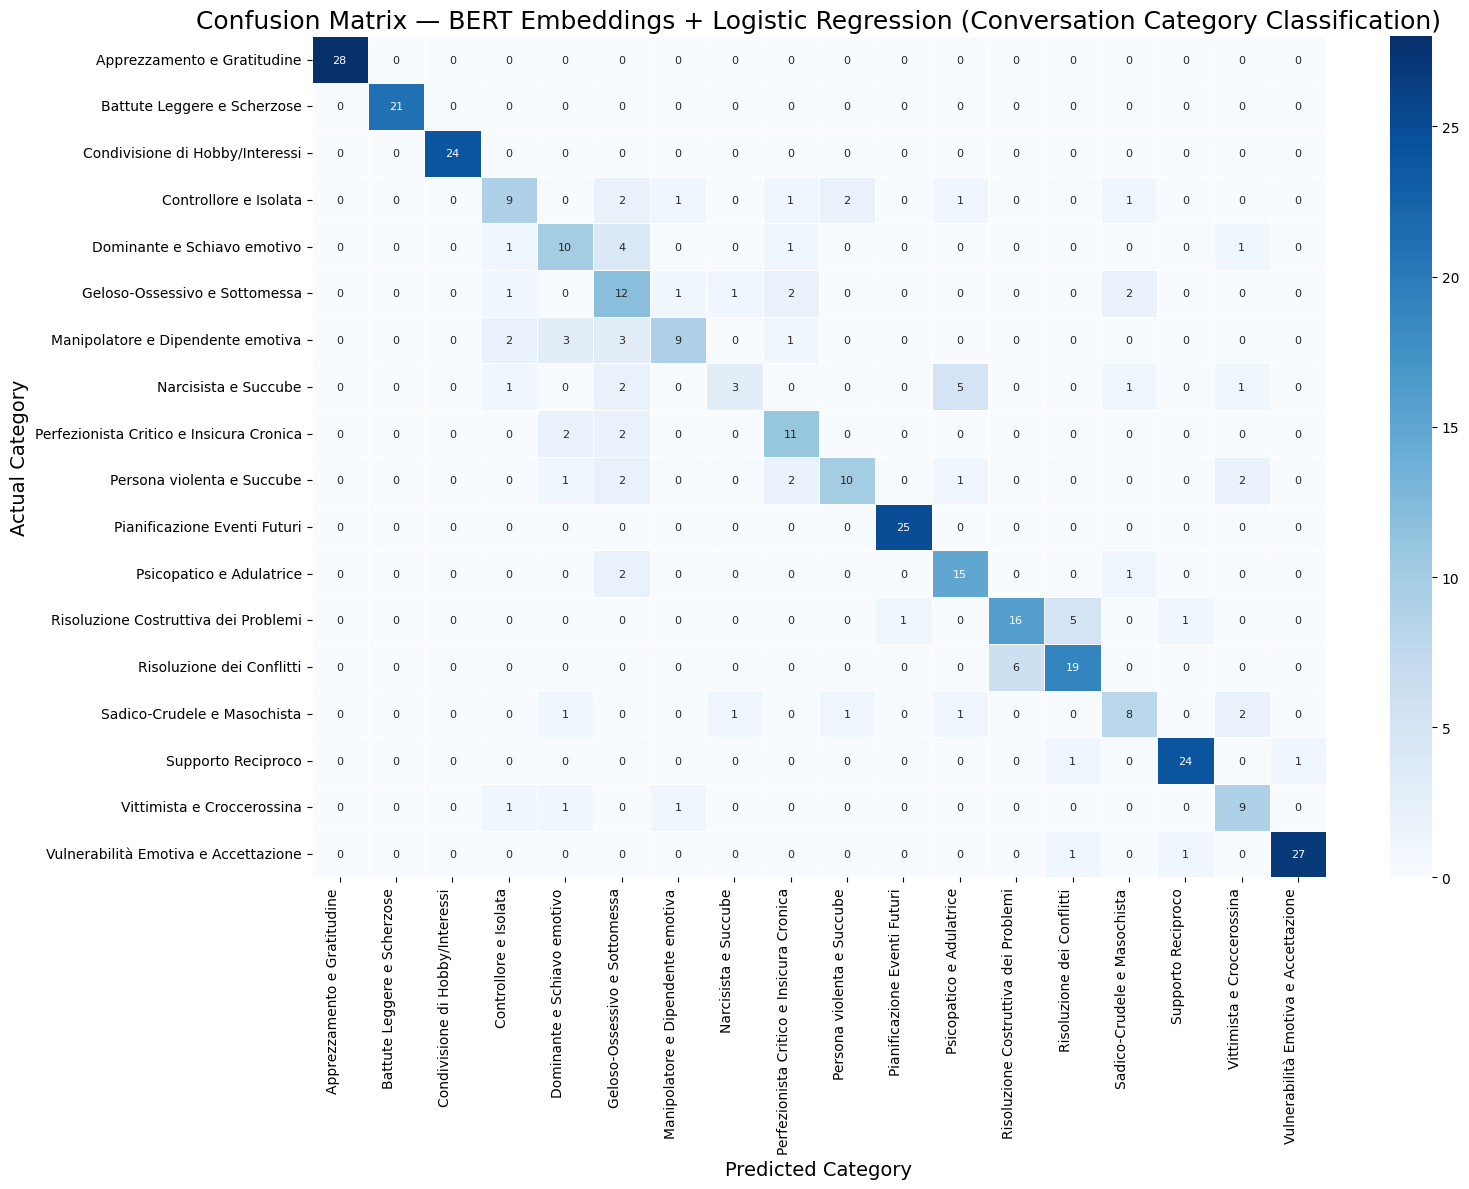


[COMPLETED] BERT Embeddings + Logistic Regression for Conversation Category Classification completed.


In [4]:
# --- SECTION 4: BERT (Embeddings Only) + Logistic Regression (Conversation Category Classification) ---

import pandas as pd
import os
import numpy as np
import torch
from transformers import BertTokenizer, BertModel # Using BertModel to extract embeddings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm # tqdm.auto for Jupyter compatibility
import matplotlib.pyplot as plt
import seaborn as sns

# Device configuration (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# --- 1. Load Dataset ---
# Using the specific path identified in your Kaggle notebook
dataset_path = "/kaggle/input/datasetunified/unified_conversation_dataset.csv"
print(f"[INFO] Loading dataset from: '{dataset_path}'")
if not os.path.exists(dataset_path):
    print(f"[ERROR] File not found: '{dataset_path}'")
    exit()

df_category = pd.read_csv(dataset_path)

# Only dropping NaNs based on the 'conversation' column, as 'person_couple' is not always present/relevant
df_category.dropna(subset=['conversation', 'conversation_category'], inplace=True) # Ensure category is not NaN

# Ensuring required columns are present before renaming
if 'conversation' not in df_category.columns:
    print("[ERROR] Column 'conversation' not found. Please check your dataset.")
    exit()
if 'conversation_category' not in df_category.columns:
    print("[ERROR] Column 'conversation_category' not found. Please check your dataset for the conversation category label.")
    print(f"Available columns: {df_category.columns.tolist()}")
    exit()

# Renaming columns for consistency: 'conversation' to 'text' and 'conversation_category' to 'label'
df_category = df_category.rename(columns={'conversation': 'text', 'conversation_category': 'label'}).copy()

print(f"[INFO] Dataset loaded with {df_category.shape[0]} valid samples for Conversation Category Classification.")

# --- 2. Encode Labels (Conversation Categories) ---
# 'label' column (conversation_category) will be string/object type, so LabelEncoder is needed
label_encoder = LabelEncoder()
df_category['label_encoded'] = label_encoder.fit_transform(df_category['label'])
class_names = list(label_encoder.classes_) # Get the actual category names

print(f"[INFO] Detected {len(class_names)} unique conversation categories: {class_names}")

# --- 3. Load BERT Model and Tokenizer ---
MODEL_NAME = 'dbmdz/bert-base-italian-uncased' # Italian BERT model
print(f"\n[INFO] Loading BERT model and tokenizer: '{MODEL_NAME}'")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Move model to device (GPU/CPU)
print(f"[INFO] BERT model loaded successfully on {device}.")

# --- 4. Extract BERT Embeddings ---
def get_bert_embedding(text, tokenizer, model, device):
    encoded_input = tokenizer(
        str(text), # Ensure input is a string
        padding=True,
        truncation=True,
        max_length=512, # Maximum sequence length
        return_tensors='pt'
    )
    encoded_input = {key: val.to(device) for key, val in encoded_input.items()}

    with torch.no_grad():
        outputs = model(**encoded_input)

    return outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()

print("\n[INFO] Generating BERT embeddings for conversations (for Category Classification)...")
tqdm.pandas(desc="BERT Embedding")
df_category['bert_embedding'] = df_category['text'].progress_apply(
    lambda x: get_bert_embedding(x, tokenizer, model, device))
print("[INFO] BERT embeddings generation completed.")

# --- 5. Prepare Data for Classifier ---
X = np.array(df_category['bert_embedding'].tolist()) # Convert list of arrays to a 2D array
y = df_category['label_encoded'].values # Encoded category labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y) # Stratified split based on categories

print(f"[INFO] Data split: {len(X_train)} training samples, {len(X_test)} test samples.")

# --- 6. Train Classifier (Logistic Regression) ---
# For multi-class classification, LogisticRegression uses 'ovr' by default, or 'multinomial' if solver supports it.
# 'lbfgs' supports 'multinomial'.
classifier = LogisticRegression(random_state=42, max_iter=2000, C=0.1, solver='lbfgs') # Ensure multi-class solver
print("\n[INFO] Training Logistic Regression classifier on BERT embeddings for Conversation Category Classification...")
classifier.fit(X_train, y_train)
print("[INFO] Training completed.")

# --- 7. Evaluation ---
print("\n[INFO] Evaluating on the test set (Conversation Category Classification)...")
y_pred = classifier.predict(X_test)

# Convert numerical predictions and test labels back to original string names for detailed report
y_test_labels_str = label_encoder.inverse_transform(y_test)
y_pred_labels_str = label_encoder.inverse_transform(y_pred)

accuracy = accuracy_score(y_test_labels_str, y_pred_labels_str)
print(f"\n[RESULT] Test Set Accuracy (Conversation Category Classification): {accuracy:.4f}")

print("\n[INFO] Detailed Classification Report (Conversation Category Classification):")
print(classification_report(y_test_labels_str, y_pred_labels_str, zero_division=0, target_names=class_names))

# --- 8. Confusion Matrix ---
print("[INFO] Plotting Confusion Matrix (Conversation Category Classification)...")
# Use numerical labels for confusion_matrix function itself
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names) # Use string class names for plotting labels

plt.figure(figsize=(16, 12)) # Increased figure size for potentially many categories
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 8}, linewidths=.5) # Reduced annotation font size
plt.title('Confusion Matrix — BERT Embeddings + Logistic Regression (Conversation Category Classification)', fontsize=18)
plt.ylabel('Actual Category', fontsize=14)
plt.xlabel('Predicted Category', fontsize=14)
plt.xticks(rotation=90, ha='right') # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n[COMPLETED] BERT Embeddings + Logistic Regression for Conversation Category Classification completed.")

[INFO] Using device: cuda
[INFO] Checking dataset file: '/kaggle/input/datasetunified/unified_conversation_dataset.csv'
[INFO] Loading dataset from: '/kaggle/input/datasetunified/unified_conversation_dataset.csv'
[INFO] Dataset loaded with 1808 valid samples for Conversation Category Fine-tuning.
[INFO] Detected 18 unique conversation categories: ['Apprezzamento e Gratitudine', 'Battute Leggere e Scherzose', 'Condivisione di Hobby/Interessi', 'Controllore e Isolata', 'Dominante e Schiavo emotivo', 'Geloso-Ossessivo e Sottomessa', 'Manipolatore e Dipendente emotiva', 'Narcisista e Succube', 'Perfezionista Critico e Insicura Cronica', 'Persona violenta e Succube', 'Pianificazione Eventi Futuri', 'Psicopatico e Adulatrice', 'Risoluzione Costruttiva dei Problemi', 'Risoluzione dei Conflitti', 'Sadico-Crudele e Masochista', 'Supporto Reciproco', 'Vittimista e Croccerossina', 'Vulnerabilità Emotiva e Accettazione']
[INFO] Split: 1446 training, 181 validation, 181 test samples
[INFO] Loading 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] BertForSequenceClassification loaded successfully on: cuda

[INFO] Starting BERT fine-tuning for Conversation Category Classification with regularization and early stopping


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,2.803100,2.557637,0.193370
2,2.057000,1.507464,0.596685
3,1.245300,0.975764,0.762431
4,0.788600,0.766757,0.795580
5,0.495900,0.683697,0.784530
6,0.300800,0.709525,0.767956
7,0.114800,0.648992,0.806630


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

[INFO] Fine-tuning completed

[INFO] Plotting learning curves...


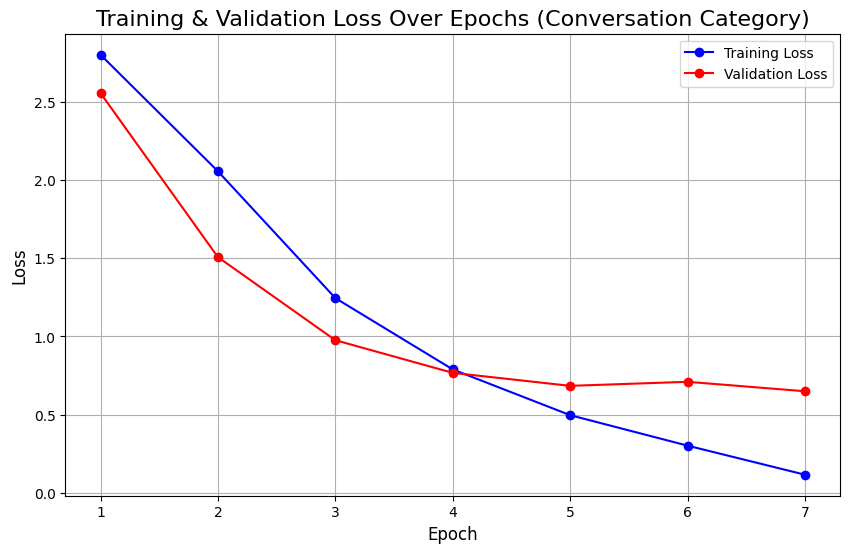


[INFO] Evaluating on test set (Conversation Category Classification)


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



[RESULT] Test set accuracy (Conversation Category Classification): 0.8232

[INFO] Detailed classification report (Conversation Category Classification):
                                          precision    recall  f1-score   support

             Apprezzamento e Gratitudine       1.00      1.00      1.00        14
             Battute Leggere e Scherzose       1.00      0.90      0.95        10
         Condivisione di Hobby/Interessi       0.92      1.00      0.96        12
                   Controllore e Isolata       1.00      0.12      0.22         8
             Dominante e Schiavo emotivo       0.88      0.78      0.82         9
           Geloso-Ossessivo e Sottomessa       0.64      0.70      0.67        10
       Manipolatore e Dipendente emotiva       0.50      0.56      0.53         9
                    Narcisista e Succube       1.00      0.43      0.60         7
Perfezionista Critico e Insicura Cronica       0.56      0.71      0.63         7
              Persona vio

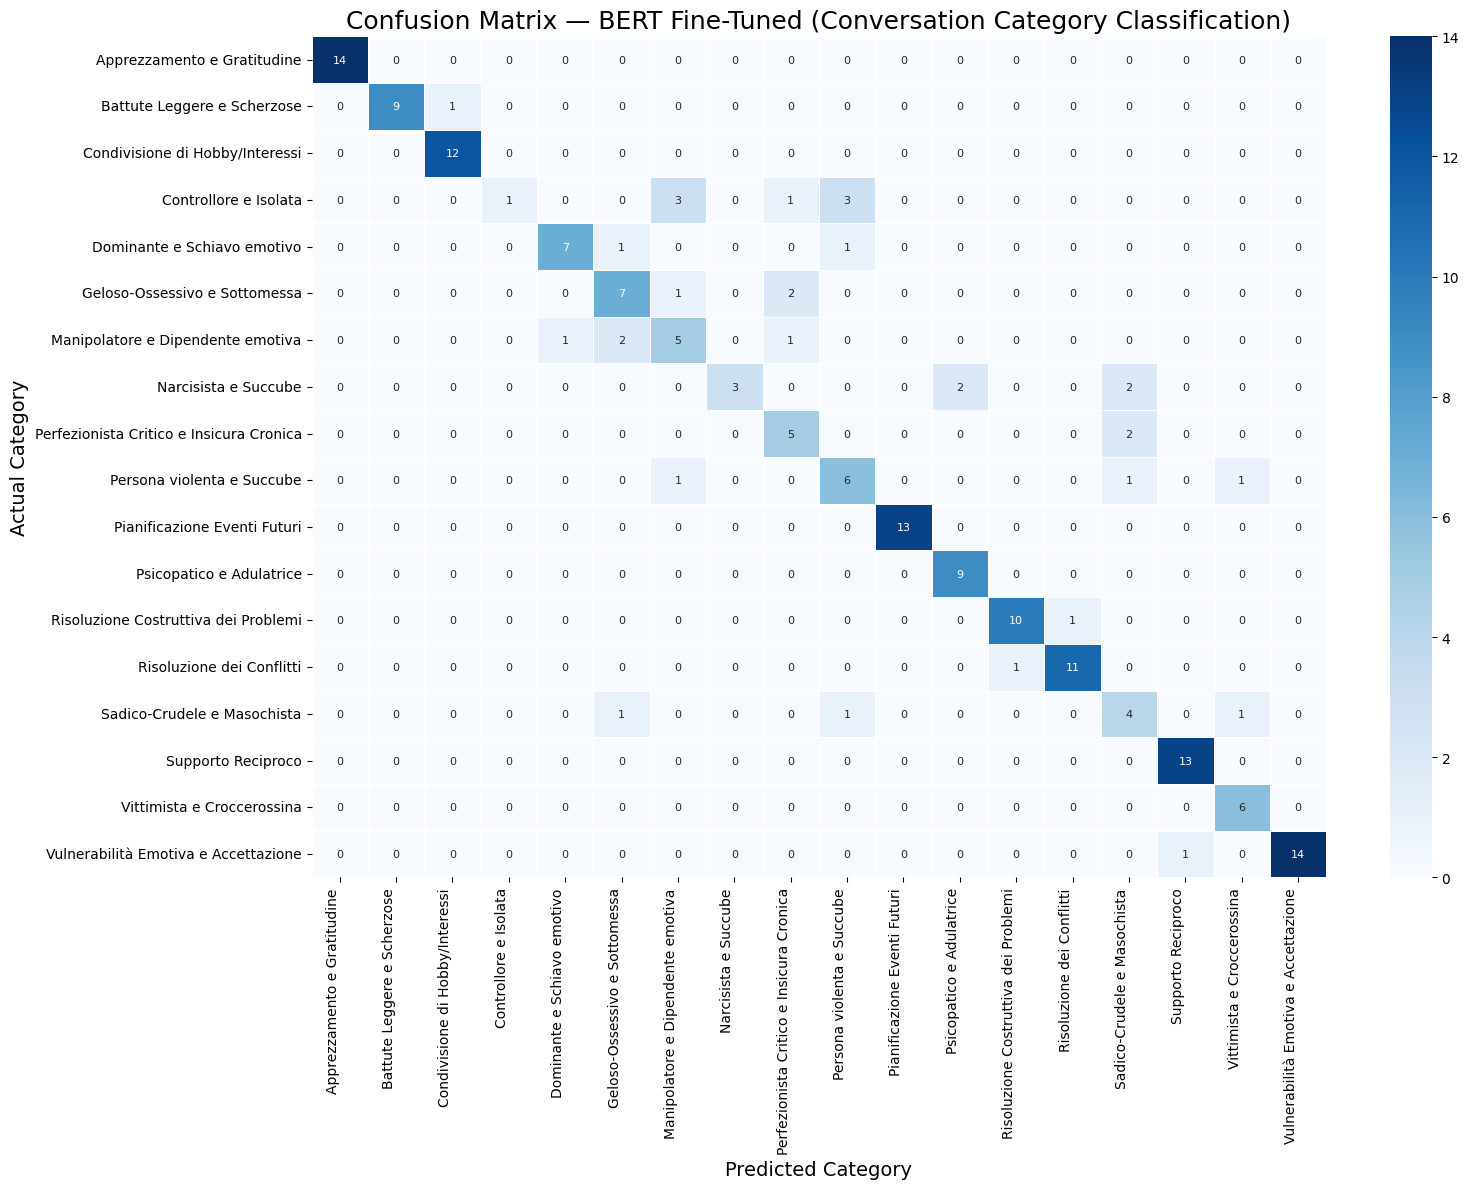


[COMPLETED] BERT Fine-tuning for Conversation Category Classification completed.


In [5]:
# --- SECTION 5: BERT Fine-tuning for Conversation Category Classification (Adapted from Friend's Code) ---

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm # Ensure tqdm.auto for Jupyter compatibility
import torch
from torch.utils.data import Dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Device configuration (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

# --- 1. Load Dataset ---
# ADAPTED: Using your Kaggle dataset path
dataset_path = "/kaggle/input/datasetunified/unified_conversation_dataset.csv"
print(f"[INFO] Checking dataset file: '{dataset_path}'")
if not os.path.exists(dataset_path):
    print(f"[ERROR] File not found: '{dataset_path}'")
    exit()

print(f"[INFO] Loading dataset from: '{dataset_path}'")
df_finetune_category = pd.read_csv(dataset_path)

# ADAPTED: Drop NaNs for 'conversation' and 'conversation_category'
df_finetune_category.dropna(subset=['conversation', 'conversation_category'], inplace=True)

# ADAPTED: Rename 'conversation' to 'text' and 'conversation_category' to 'label'
# for consistency with the friend's code structure
if 'conversation' not in df_finetune_category.columns:
    print("[ERROR] Column 'conversation' not found. Please check your dataset.")
    exit()
if 'conversation_category' not in df_finetune_category.columns:
    print("[ERROR] Column 'conversation_category' not found. Please check your dataset.")
    print(f"Available columns: {df_finetune_category.columns.tolist()}")
    exit()

df_finetune_category.rename(columns={'conversation': 'text', 'conversation_category': 'label'}, inplace=True)
print(f"[INFO] Dataset loaded with {df_finetune_category.shape[0]} valid samples for Conversation Category Fine-tuning.")

# --- 2. Encode Labels (Conversation Categories) ---
label_encoder = LabelEncoder()
df_finetune_category['label_encoded'] = label_encoder.fit_transform(df_finetune_category['label'])
class_names = list(label_encoder.classes_)
num_labels = len(class_names)
id2label = {i: label for i, label in enumerate(class_names)}
label2id = {label: i for i, label in enumerate(class_names)}

print(f"[INFO] Detected {num_labels} unique conversation categories: {class_names}")

# --- 3. Split Data (Train, Validation, Test) ---
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_finetune_category['text'].tolist(), df_finetune_category['label_encoded'].tolist(),
    test_size=0.2, random_state=42, stratify=df_finetune_category['label_encoded'].tolist()
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5, random_state=42, stratify=temp_labels
)
print(f"[INFO] Split: {len(train_texts)} training, {len(val_texts)} validation, {len(test_texts)} test samples")

# --- 4. Tokenizer and Custom Dataset Class ---
MODEL_NAME = 'dbmdz/bert-base-italian-uncased'
print(f"[INFO] Loading BERT model & tokenizer: '{MODEL_NAME}'")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

class ConversationCategoryDataset(Dataset): # Renamed class for clarity
    def __init__(self, texts, labels, tokenizer, max_len):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len)
        self.labels = labels
        self.tokenizer = tokenizer # Store tokenizer for potential future use

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

MAX_LEN = 512 # Max sequence length for BERT input, consistent with friend's code
train_dataset = ConversationCategoryDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = ConversationCategoryDataset(val_texts, val_labels, tokenizer, MAX_LEN)
test_dataset = ConversationCategoryDataset(test_texts, test_labels, tokenizer, MAX_LEN)
print(f"[INFO] Custom datasets created with max_len: {MAX_LEN}.")

# --- 5. Load BERT Model for Sequence Classification ---
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_labels, id2label=id2label, label2id=label2id
)
model.to(device)
print(f"[INFO] BertForSequenceClassification loaded successfully on: {device}")

# --- 6. Training Setup ---
def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

training_args = TrainingArguments(
    output_dir='./results_bert_finetuned_conversation_category', # ADAPTED output directory
    save_total_limit=1,
    num_train_epochs=7, # You might adjust this. EarlyStopping is active.
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_bert_conversation_category', # ADAPTED log directory
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="loss", # Often 'accuracy' or 'f1' is preferred for classification
    greater_is_better=False, # True if metric_for_best_model is accuracy/f1, False if loss
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Stop if validation loss doesn't improve for 2 epochs
)

# --- 7. Fine-Tune BERT ---
print("\n[INFO] Starting BERT fine-tuning for Conversation Category Classification with regularization and early stopping")
trainer.train()
print("[INFO] Fine-tuning completed")

# --- 8. Plot Learning Curves ---
print("\n[INFO] Plotting learning curves...")
log_history = trainer.state.log_history
train_loss = [log['loss'] for log in log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
epochs_eval = [log['epoch'] for log in log_history if 'eval_loss' in log] # Epochs for eval loss

# Ensure lengths match for plotting. Training loss is typically logged more frequently than eval_loss
# We need to map train_loss to epochs corresponding to eval_loss.
# For simplicity, if logging_strategy="epoch", then len(train_loss) == len(eval_loss) == len(epochs_eval)
# If logging_strategy is 'steps' or more frequent, you'd need to align them.
# Assuming logging_strategy="epoch" makes this straightforward.

plt.figure(figsize=(10, 6))
plt.plot(epochs_eval, train_loss[:len(epochs_eval)], 'b-o', label='Training Loss') # Slice train_loss to match eval_loss length
plt.plot(epochs_eval, eval_loss, 'r-o', label='Validation Loss')
plt.title('Training & Validation Loss Over Epochs (Conversation Category)', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- 9. Evaluation on Test Set ---
print("\n[INFO] Evaluating on test set (Conversation Category Classification)")
test_results = trainer.predict(test_dataset)
y_pred_encoded = np.argmax(test_results.predictions, axis=-1)
y_test_encoded = test_results.label_ids

# Convert numerical predictions and true labels back to original string names for detailed report
y_pred_labels_str = label_encoder.inverse_transform(y_pred_encoded)
y_test_labels_str = label_encoder.inverse_transform(y_test_encoded)

accuracy = accuracy_score(y_test_labels_str, y_pred_labels_str)
print(f"\n[RESULT] Test set accuracy (Conversation Category Classification): {accuracy:.4f}")

print("\n[INFO] Detailed classification report (Conversation Category Classification):")
print(classification_report(y_test_labels_str, y_pred_labels_str, zero_division=0, target_names=class_names))

# --- 10. Confusion Matrix ---
print("[INFO] Plotting confusion matrix (Conversation Category Classification)")
# Use numerical labels for confusion_matrix function itself
conf_matrix = confusion_matrix(y_test_encoded, y_pred_encoded, labels=np.arange(num_labels))
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names) # Use string names for plot

plt.figure(figsize=(16, 12)) # Adjust size for many categories
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 8}, linewidths=.5)
plt.title('Confusion Matrix — BERT Fine-Tuned (Conversation Category Classification)', fontsize=18)
plt.ylabel('Actual Category', fontsize=14)
plt.xlabel('Predicted Category', fontsize=14)
plt.xticks(rotation=90, ha='right') # Rotate for readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n[COMPLETED] BERT Fine-tuning for Conversation Category Classification completed.")

[INFO] Using device: cuda
[INFO] Loading dataset from: /kaggle/input/datasetunified/unified_conversation_dataset.csv
[INFO] Found 620 toxic conversations to process for most toxic sentence extraction.
[INFO] Extracted 5965 individual messages (sentences) from toxic conversations.
[INFO] Distribution of labels (0=Non-Toxic Sentence, 1=Toxic Sentence):
label
0    0.916681
1    0.083319
Name: proportion, dtype: float64
[INFO] Loading model and tokenizer: dbmdz/bert-base-italian-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-italian-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[INFO] Split: 4772 training samples, 596 validation samples, 597 test samples

[INFO] Starting training for Most Toxic Sentence Classifier...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.176400,0.234912,0.917785
2,0.239200,0.210527,0.916107
3,0.174500,0.222573,0.912752


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[INFO] Training completed.

[INFO] Plotting learning curves...


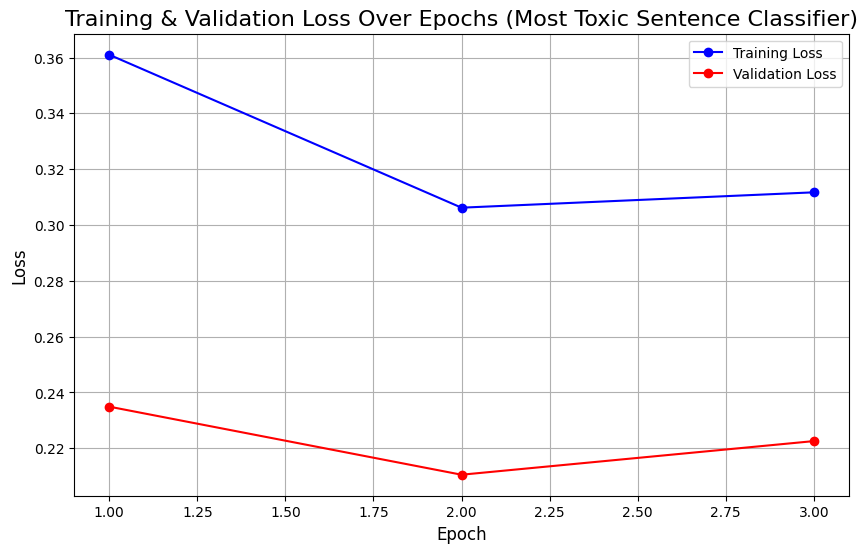


[INFO] Evaluating on test set (Most Toxic Sentence Classifier)...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



[RESULT] Test set accuracy (Most Toxic Sentence Classifier): 0.9162

[INFO] Detailed classification report (Most Toxic Sentence Classifier):
                    precision    recall  f1-score   support

Non-Toxic Sentence       0.92      1.00      0.96       547
    Toxic Sentence       0.00      0.00      0.00        50

          accuracy                           0.92       597
         macro avg       0.46      0.50      0.48       597
      weighted avg       0.84      0.92      0.88       597

[INFO] Plotting confusion matrix (Most Toxic Sentence Classifier)


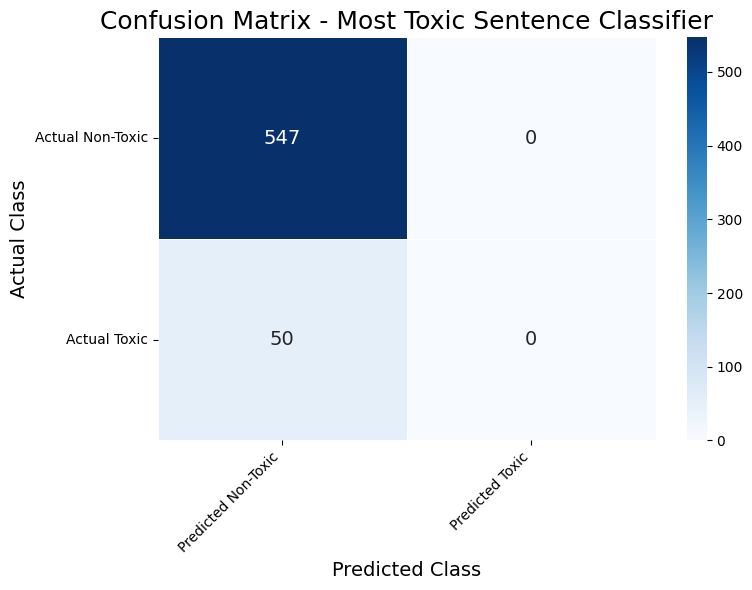


[INFO] Example prediction on new data:
Conversation Category: 'Litigio'
Original Conversation: ["Ciao, come stai?", "Sei un completo idiota e non capisci niente!", "Forse dovremmo parlarne con calma.", "Spero tu abbia una buona giornata."]

Identified Most Toxic Sentence: 'Sei un completo idiota e non capisci niente!' (Toxic Score: 0.0837)

All sentences and their toxic scores:
- 'Ciao, come stai?' (Score: 0.0061)
- 'Sei un completo idiota e non capisci niente!' (Score: 0.0837)
- 'Forse dovremmo parlarne con calma.' (Score: 0.0075)
- 'Spero tu abbia una buona giornata.' (Score: 0.0099)

[COMPLETED] BERT Fine-tuning for Most Toxic Sentence Identification completed.


In [2]:
# --- SECTION 7: BERT Fine-tuning for Most Toxic Sentence Identification ---

import re
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, Subset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Configurazione Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Using device: {device}")

# --- 2. Caricamento e Preparazione Dataset ---
# ADAPTED: Using your Kaggle dataset path
dataset_path = "/kaggle/input/datasetunified/unified_conversation_dataset.csv"
print(f"[INFO] Loading dataset from: {dataset_path}")
try:
    df = pd.read_csv(dataset_path)
except FileNotFoundError:
    print(f"[ERROR] File not found: '{dataset_path}'. Please check the path.")
    exit()

# ADAPTED: Filter for conversations explicitly marked as toxic (using 'toxic_label' column)
# Also ensure essential columns are not null for this specific task
df.dropna(subset=['conversation', 'most_toxic_sentence', 'toxic_label', 'conversation_category'], inplace=True)
df = df[df["toxic_label"] == 1].reset_index(drop=True)

print(f"[INFO] Found {df.shape[0]} toxic conversations to process for most toxic sentence extraction.")

# --- 3. Estrazione dei messaggi e etichettatura ---
# This function identifies the most toxic sentence within a conversation's messages
def split_conversation_and_label_toxic_sentence(row):
    messages = re.findall(r'"([^\"]+)"', row["conversation"])
    toxic_phrase_from_df = str(row["most_toxic_sentence"]).strip() # Ensure string for comparison
    
    result = []
    found_toxic_in_messages = False # Flag to check if toxic_phrase is found among split messages

    for msg in messages:
        msg_strip = msg.strip()
        # Label is 1 if the identified toxic phrase is found within the current message
        # Use 'in' for substring check, as messages might contain more than just the exact toxic phrase
        label = 1 if toxic_phrase_from_df in msg_strip else 0
        
        if label == 1:
            found_toxic_in_messages = True

        result.append({
            "conversation_category": row["conversation_category"], # ADAPTED: Using conversation_category
            "sentence": msg_strip,
            "label": label
        })
    
    # Optional: If the most_toxic_sentence was not found in any of the split messages,
    # you might want to skip this conversation or handle it.
    # For now, we proceed as is, but it's a potential data quality issue.
    if not found_toxic_in_messages and messages:
        # print(f"[WARN] Most toxic sentence '{toxic_phrase_from_df}' not found in any split message for conversation ID {row.name}")
        # If the toxic sentence is not found, it might lead to '0' labels for all messages in that conversation,
        # which might not be ideal if we assume at least one toxic sentence exists.
        # For robustness, we might want to ensure at least one label is 1 if the conversation is marked toxic.
        # However, for simplicity now, we rely on the direct comparison.
        pass

    return result

rows = []
# tqdm.pandas(desc="Processing conversations") # Uncomment for progress bar if needed
for _, row in df.iterrows(): # df now contains only toxic conversations
    rows.extend(split_conversation_and_label_toxic_sentence(row))

sent_df = pd.DataFrame(rows)

# Filter out rows where 'sentence' might be empty after splitting (e.g., if re.findall picks up empty strings)
sent_df.dropna(subset=['sentence'], inplace=True)
sent_df = sent_df[sent_df['sentence'].str.strip() != '']

print(f"[INFO] Extracted {len(sent_df)} individual messages (sentences) from toxic conversations.")
print(f"[INFO] Distribution of labels (0=Non-Toxic Sentence, 1=Toxic Sentence):")
print(sent_df['label'].value_counts(normalize=True))

# --- 4. Custom Dataset Class ---
class ToxicSentenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        sentence = str(r['sentence']) # Ensure sentence is string
        # ADAPTED: Use conversation_category as context
        context = str(r['conversation_category']) if 'conversation_category' in r else "" 
        
        # Tokenizer input with context (as pair)
        encoding = self.tokenizer(
            sentence, context, # First sequence is sentence, second is context
            truncation='only_first', # Truncate only the first sequence if too long
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(r['label'], dtype=torch.long)
        }

# --- 5. Tokenizer e Modello ---
MODEL_NAME = 'dbmdz/bert-base-italian-uncased'
print(f"[INFO] Loading model and tokenizer: {MODEL_NAME}")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

dataset = ToxicSentenceDataset(sent_df, tokenizer)
labels = sent_df['label'].tolist()
indices = list(range(len(dataset)))

# --- 6. Split dati (Train, Validation, Test) ---
# Stratify on the new sentence-level labels
train_idx, temp_idx = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42)
temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=temp_labels, random_state=42)

train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)
test_ds = Subset(dataset, test_idx)

print(f"[INFO] Split: {len(train_ds)} training samples, {len(val_ds)} validation samples, {len(test_ds)} test samples")

# --- 7. Metriche ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

# --- 8. Trainer Config ---
training_args = TrainingArguments(
    output_dir='./results_most_toxic_sentence_classifier', # ADAPTED output directory
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16, # Adjusted batch size for potential memory constraints
    per_device_eval_batch_size=16, # Adjusted batch size
    num_train_epochs=7,
    weight_decay=0.01,
    logging_dir='./logs_most_toxic_sentence_classifier', # ADAPTED log directory
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy", # Using accuracy as metric for binary classification
    greater_is_better=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# --- 9. Training ---
print("\n[INFO] Starting training for Most Toxic Sentence Classifier...")
trainer.train()
print("[INFO] Training completed.")

# --- 10. Learning Curves ---
print("\n[INFO] Plotting learning curves...")
log_history = trainer.state.log_history
train_loss = [log['loss'] for log in log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
epochs_eval = [log['epoch'] for log in log_history if 'eval_loss' in log]

# Calculate average training loss per epoch if logged more frequently than once per epoch
loss_df = pd.DataFrame({'epoch': [log['epoch'] for log in log_history if 'loss' in log], 
                        'loss': [log['loss'] for log in log_history if 'loss' in log]})
avg_train_loss = loss_df.groupby('epoch').mean()['loss'].tolist()

plt.figure(figsize=(10, 6))
# Ensure lengths match for plotting, taking only relevant avg_train_loss points
plt.plot(epochs_eval, avg_train_loss[:len(epochs_eval)], 'b-o', label='Training Loss')
plt.plot(epochs_eval, eval_loss, 'r-o', label='Validation Loss')
plt.title('Training & Validation Loss Over Epochs (Most Toxic Sentence Classifier)', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- 11. Evaluation on Test Set ---
print("\n[INFO] Evaluating on test set (Most Toxic Sentence Classifier)...")
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

accuracy = accuracy_score(y_true, y_pred)
print(f"\n[RESULT] Test set accuracy (Most Toxic Sentence Classifier): {accuracy:.4f}")

print("\n[INFO] Detailed classification report (Most Toxic Sentence Classifier):")
print(classification_report(y_true, y_pred, zero_division=0, target_names=['Non-Toxic Sentence', 'Toxic Sentence']))

# --- 12. Confusion Matrix ---
print("[INFO] Plotting confusion matrix (Most Toxic Sentence Classifier)")
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Non-Toxic', 'Actual Toxic'], columns=['Predicted Non-Toxic', 'Predicted Toxic'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14}, linewidths=.5)
plt.title('Confusion Matrix - Most Toxic Sentence Classifier', fontsize=18)
plt.ylabel('Actual Class', fontsize=14)
plt.xlabel('Predicted Class', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 13. Predict Most Toxic Sentence in a New Conversation ---
def predict_most_toxic(conversation: str, conversation_category: str, model, tokenizer, device, max_len=128):
    messages = re.findall(r'"([^\"]+)"', conversation)
    if not messages:
        print("[WARN] No messages found in the conversation.")
        return None, 0.0, []
    
    # Prepare inputs for all messages
    sentences = [msg.strip() for msg in messages]
    contexts = [conversation_category] * len(sentences)

    # Tokenize all sentences in a batch
    encodings = tokenizer(
        sentences, contexts, # First sequence is sentence, second is context
        truncation='only_first', 
        padding='max_length', 
        max_length=max_len,
        return_tensors='pt'
    )
    
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)
    
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits
        probs = torch.nn.functional.softmax(logits, dim=-1) # Get probabilities for both classes
    
    # We are interested in the probability of being 'Toxic' (class 1)
    toxic_probs = probs[:, 1]
    
    if toxic_probs.numel() == 0: # Check if tensor is empty
        return None, 0.0, []

    # Get the index of the sentence with the highest toxic probability
    idx = torch.argmax(toxic_probs).item()
    
    # Return all sentences with their toxic probabilities (for potential display)
    sentences_with_probs = [(s, p.item()) for s, p in zip(sentences, toxic_probs)]

    return sentences[idx], toxic_probs[idx].item(), sentences_with_probs

print("\n[INFO] Example prediction on new data:")
example_convo = '["Ciao, come stai?", "Sei un completo idiota e non capisci niente!", "Forse dovremmo parlarne con calma.", "Spero tu abbia una buona giornata."]'
example_category = "Litigio" # ADAPTED: Using a relevant conversation category

most_toxic_sentence, score, all_sentences_with_probs = predict_most_toxic(example_convo, example_category, model, tokenizer, device, MAX_LEN)

print(f"Conversation Category: '{example_category}'")
print(f"Original Conversation: {example_convo}")
print(f"\nIdentified Most Toxic Sentence: '{most_toxic_sentence}' (Toxic Score: {score:.4f})")
print("\nAll sentences and their toxic scores:")
for sentence, prob in all_sentences_with_probs:
    print(f"- '{sentence}' (Score: {prob:.4f})")

print("\n[COMPLETED] BERT Fine-tuning for Most Toxic Sentence Identification completed.")

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=3ceef680f8741d2ae801079cab1fb8329a124d914e8d76443bd48604aadf9f54
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
[INFO] Using device: cuda
[INFO] Loading dataset from: /kaggle/input/datasetunified/unified_conversation_dataset.csv
[INFO] Found 620 toxic conversations to use for generation fine-tuning.
[INFO] Data split: 496 training samples, 62 validation samples, 62 test samples.
[INFO] Loading model and tokenizer: facebook/bart-base


config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

[INFO] Datasets and DataCollator initialized. Model 'facebook/bart-base' loaded on cuda.

[INFO] Starting BART fine-tuning for Most Toxic Sentence Generation...


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze 

Epoch,Training Loss,Validation Loss
1,No log,1.177725
2,2.793100,0.202613
3,2.793100,0.112295
4,0.304600,0.103486
5,0.143900,0.075756
6,0.143900,0.071428
7,0.116400,0.072163


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and retur

[INFO] BART fine-tuning completed.

[INFO] Generating learning curves...


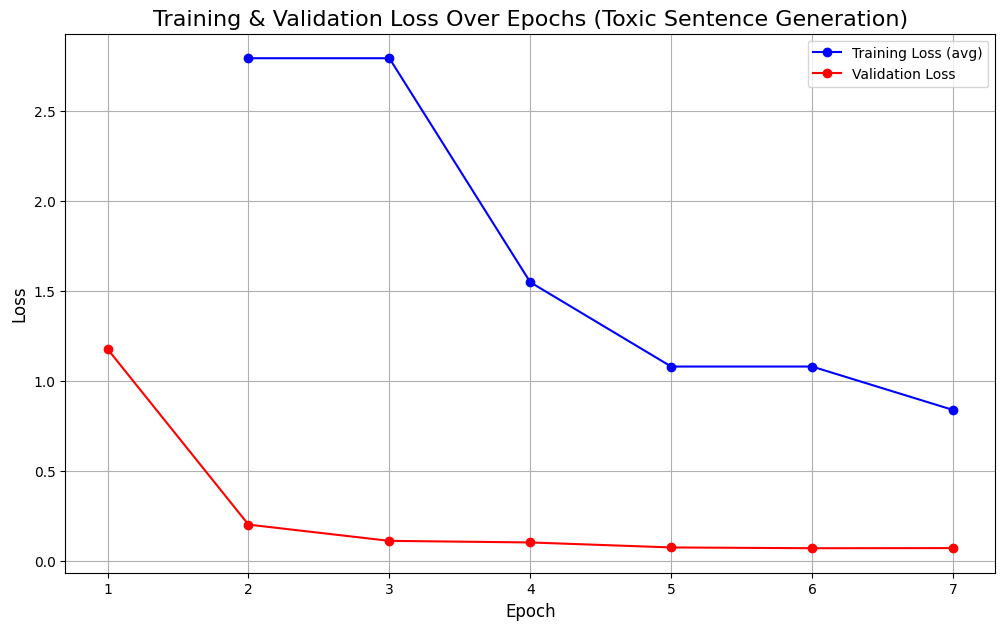


[INFO] Evaluating model on test set for generation quality (BLEU & ROUGE)...


Evaluating Generation:   0%|          | 0/62 [00:00<?, ?it/s]


[RESULT] Test set performance for Toxic Sentence Generation:


,Metric,Average Score
0,BLEU,0.305912
1,ROUGE-1,0.434351
2,ROUGE-2,0.369472
3,ROUGE-L,0.424525



[INFO] Example generation on new data:
Input Conversation: ["Sei sempre in ritardo, non mi ascolti mai.", "Non voglio più vederti, sei una delusione.", "Dobbiamo lavorare sulla nostra comunicazione."]
Conversation Category: Litigio
Generated Most Toxic Sentence: 'Sei sempre in ritardo, non mi ascolti mai.'

[COMPLETED] BART Fine-tuning for Most Toxic Sentence Generation completed.


In [5]:
# --- SECTION 8: BART Fine-tuning for Most Toxic Sentence Generation ---
!pip install rouge_score

import re
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, Subset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM, # For BART, which is a Seq2Seq model
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq, # Essential for Seq2Seq padding/labels
    EarlyStoppingCallback
)
from sklearn.model_selection import GroupShuffleSplit
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction # For BLEU score
from rouge_score import rouge_scorer # For ROUGE score
import matplotlib.pyplot as plt
import seaborn as sns # Used for general plotting, though not explicitly in friend's generation plotting
from tqdm.auto import tqdm # For progress bars

# --- 1. Device Configuration ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Using device: {device}")

# --- 2. Load and Filter Dataset ---
# ADAPTED: Using your Kaggle dataset path
dataset_path = "/kaggle/input/datasetunified/unified_conversation_dataset.csv"
print(f"[INFO] Loading dataset from: {dataset_path}")
try:
    df_gen = pd.read_csv(dataset_path)
except FileNotFoundError:
    print(f"[ERROR] File not found: '{dataset_path}'. Please ensure it's in the correct Kaggle input directory.")
    exit()

# ADAPTED: Filter for conversations explicitly marked as toxic (using 'toxic_label' column)
# Ensure essential columns exist and are not null for this task
required_cols = ['conversation', 'most_toxic_sentence', 'toxic_label', 'conversation_category']
for col in required_cols:
    if col not in df_gen.columns:
        print(f"[ERROR] Required column '{col}' not found in the dataset. Available columns: {df_gen.columns.tolist()}")
        exit()

df_gen.dropna(subset=required_cols, inplace=True)
df_gen = df_gen[df_gen["toxic_label"] == 1].reset_index(drop=True)

print(f"[INFO] Found {df_gen.shape[0]} toxic conversations to use for generation fine-tuning.")

# --- 3. Dataset Class for Text Generation ---
class ToxicSentenceGenerationDataset(Dataset): # Renamed class for clarity
    def __init__(self, df, tokenizer, max_input_len=512, max_target_len=64):
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

        # Input: "Conversazione: [conversation] Categoria: [conversation_category]"
        # Target: "most_toxic_sentence"
        self.inputs = [
            f"Conversazione: {row['conversation']} Categoria: {row['conversation_category']}" 
            for _, row in df.iterrows()
        ]
        self.targets = [str(row['most_toxic_sentence']) for _, row in df.iterrows()] # Ensure target is string

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_text = self.inputs[idx]
        target_text = self.targets[idx]

        # Tokenize input (conversation + category)
        input_encoding = self.tokenizer(
            input_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_input_len,
            return_tensors='pt'
        )

        # Tokenize target (most toxic sentence)
        with self.tokenizer.as_target_tokenizer(): # Context manager for target tokenization in some models
             target_encoding = self.tokenizer(
                target_text,
                truncation=True,
                padding='max_length',
                max_length=self.max_target_len,
                return_tensors='pt'
            )

        return {
            'input_ids': input_encoding['input_ids'].flatten(),
            'attention_mask': input_encoding['attention_mask'].flatten(),
            'labels': target_encoding['input_ids'].flatten() # Labels are the input_ids of the target sequence
        }

# --- 4. Split Dataset ---
# Using GroupShuffleSplit for reproducibility and potentially keeping related data together if indices matter
# Here, we use df_gen.index as groups, meaning each conversation is treated as a group.
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, temp_idx = next(gss.split(df_gen, groups=df_gen.index)) # Use df_gen.index as groups

temp_df = df_gen.iloc[temp_idx].reset_index(drop=True) # Create a temporary DataFrame for validation/test split
temp_labels_for_stratify = df_gen.iloc[temp_idx]['toxic_label'].tolist() # Use toxic_label for stratify on temp_df

# Use GroupShuffleSplit again for val/test split, stratifying if possible
# Note: For generation, stratification might be less critical than for classification, but good practice.
gss2 = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(gss2.split(temp_df, groups=temp_df.index)) # Use temp_df.index as groups

val_idx_original = temp_df.iloc[val_idx_rel].index.tolist() # Get original indices from df_gen
test_idx_original = temp_df.iloc[test_idx_rel].index.tolist() # Get original indices from df_gen

train_df = df_gen.iloc[train_idx].reset_index(drop=True)
val_df = df_gen.iloc[val_idx_original].reset_index(drop=True)
test_df = df_gen.iloc[test_idx_original].reset_index(drop=True)

print(f"[INFO] Data split: {len(train_df)} training samples, {len(val_df)} validation samples, {len(test_df)} test samples.")

# --- 5. Tokenizer and Model ---
model_name = "facebook/bart-base" # BART model is suitable for Seq2Seq generation
print(f"[INFO] Loading model and tokenizer: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

train_dataset = ToxicSentenceGenerationDataset(train_df, tokenizer)
val_dataset = ToxicSentenceGenerationDataset(val_df, tokenizer)
test_dataset = ToxicSentenceGenerationDataset(test_df, tokenizer)

# Data collator is crucial for Seq2Seq models to correctly pad and handle labels
collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding='longest')

print(f"[INFO] Datasets and DataCollator initialized. Model '{model_name}' loaded on {device}.")

# --- 6. Trainer Configuration ---
training_args = TrainingArguments(
    output_dir="./results_bart_toxic_sentence_gen", # ADAPTED output directory
    per_device_train_batch_size=4, # Batch size for training
    per_device_eval_batch_size=4,  # Batch size for evaluation
    num_train_epochs=7,            # Max epochs, EarlyStopping will manage actual epochs
    learning_rate=3e-5,            # Learning rate (common for fine-tuning)
    eval_strategy="epoch",         # Evaluate after each epoch
    save_strategy="epoch",         # Save checkpoint after each epoch
    logging_steps=100,             # Log every N steps
    fp16=torch.cuda.is_available(),# Enable mixed precision training if CUDA is available
    load_best_model_at_end=True,   # Load the best model after training completes
    metric_for_best_model="eval_loss", # Monitor validation loss for best model
    greater_is_better=False,       # Lower loss is better
    report_to="none"               # Disable logging to external services
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collator, # Use the data collator here
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Stop if eval_loss doesn't improve for 2 epochs
)

# --- 7. Train BART Model ---
print("\n[INFO] Starting BART fine-tuning for Most Toxic Sentence Generation...")
trainer.train()
print("[INFO] BART fine-tuning completed.")

# --- 8. Learning Curves ---
print("\n[INFO] Generating learning curves...")
log_history = trainer.state.log_history
train_logs = [log for log in log_history if 'loss' in log]
eval_logs = [log for log in log_history if 'eval_loss' in log]

eval_loss = [log['eval_loss'] for log in eval_logs]
epochs_eval = [log['epoch'] for log in eval_logs]

train_loss_df = pd.DataFrame(train_logs)
avg_train_loss = []
# Calculate average training loss per epoch, matching the evaluation epochs
for epoch in epochs_eval:
    # Get all training loss entries up to and including the current epoch for averaging
    current_epoch_train_losses = [log['loss'] for log in train_logs if log['epoch'] <= epoch]
    if current_epoch_train_losses:
        avg_train_loss.append(np.mean(current_epoch_train_losses))
    else: # Should not happen if epochs_eval is well-formed
        avg_train_loss.append(None) # Or handle as appropriate

# Filter out None values if any
epochs_eval_filtered = [e for e, l in zip(epochs_eval, avg_train_loss) if l is not None]
avg_train_loss_filtered = [l for l in avg_train_loss if l is not None]


plt.figure(figsize=(12, 7))
plt.plot(epochs_eval_filtered, avg_train_loss_filtered, 'b-o', label='Training Loss (avg)')
plt.plot(epochs_eval, eval_loss, 'r-o', label='Validation Loss')
plt.title('Training & Validation Loss Over Epochs (Toxic Sentence Generation)', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(epochs_eval)
plt.show()

# --- 9. Prediction Function ---
def generate_most_toxic_sentence(conversation: str, conversation_category: str, model, tokenizer, device, max_gen_len=64):
    # ADAPTED: Input format for the model matches training: "Conversazione: [conversation] Categoria: [conversation_category]"
    input_text = f"Conversazione: {conversation} Categoria: {conversation_category}"
    
    enc = tokenizer(input_text, return_tensors='pt').to(device)
    model.eval() # Set model to evaluation mode
    
    with torch.no_grad():
        # Parameters for generation:
        # max_new_tokens: maximum length of the generated output
        # num_beams: for beam search (helps find better sequences, usually 4-5 is good)
        # early_stopping: stops generation if all beam hypotheses are worse than a finished hypothesis
        # no_repeat_ngram_size: penalizes n-grams that appear more than once in the generated text
        # temperature: controls randomness (higher = more random)
        # top_k, top_p: for nucleus sampling (alternative to beam search for more diverse outputs)
        output_tokens = model.generate(
            input_ids=enc['input_ids'], 
            attention_mask=enc['attention_mask'],
            max_new_tokens=max_gen_len,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=2, # Prevents repetitive phrases
            temperature=1.0, # Default temperature
            do_sample=False # Set to True for sampling, False for greedy/beam search
        )
        
    return tokenizer.decode(output_tokens[0], skip_special_tokens=True)

# --- 10. Evaluation on Test Set ---
print("\n[INFO] Evaluating model on test set for generation quality (BLEU & ROUGE)...")
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smooth = SmoothingFunction().method1 # Smoothing function for BLEU score

bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

# tqdm for progress bar during evaluation
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating Generation"):
    conv = row['conversation']
    category = row['conversation_category'] # Get category for input
    target = str(row['most_toxic_sentence']).strip() # Ensure target is string and stripped
    
    prediction = generate_most_toxic_sentence(conv, category, model, tokenizer, device, MAX_LEN) # Use MAX_LEN or appropriate gen length
    
    # BLEU score: NLTK expects list of reference sentences and a candidate sentence
    # Target is single sentence, so [target.split()]
    bleu = sentence_bleu([target.split()], prediction.split(), smoothing_function=smooth)
    bleu_scores.append(bleu)
    
    # ROUGE scores
    scores = scorer.score(target, prediction)
    rouge1_scores.append(scores['rouge1'].fmeasure)
    rouge2_scores.append(scores['rouge2'].fmeasure)
    rougeL_scores.append(scores['rougeL'].fmeasure)

avg_bleu = sum(bleu_scores) / len(bleu_scores)
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)

results_df = pd.DataFrame({
    'Metric': ['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
    'Average Score': [avg_bleu, avg_rouge1, avg_rouge2, avg_rougeL]
})

print("\n[RESULT] Test set performance for Toxic Sentence Generation:")
display(results_df)

# --- 11. Example Generation ---
print("\n[INFO] Example generation on new data:")
example_convo_gen = '["Sei sempre in ritardo, non mi ascolti mai.", "Non voglio più vederti, sei una delusione.", "Dobbiamo lavorare sulla nostra comunicazione."]'
example_category_gen = "Litigio" # Provide a relevant category for the example

generated_toxic_sentence = generate_most_toxic_sentence(
    example_convo_gen, 
    example_category_gen, 
    model, tokenizer, device, MAX_LEN
)

print(f"Input Conversation: {example_convo_gen}")
print(f"Conversation Category: {example_category_gen}")
print(f"Generated Most Toxic Sentence: '{generated_toxic_sentence}'")

print("\n[COMPLETED] BART Fine-tuning for Most Toxic Sentence Generation completed.")